In [1]:
from sea_breeze import load_model_data, utils
import xarray as xr
from dask.distributed import Client
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import hvplot.xarray
import numpy as np
import logging
import matplotlib as mpl

mpl.rcParams['hatch.linewidth'] = 0.5  # previous pdf hatch linewidth
logging.getLogger("flox").setLevel(logging.WARNING)

In [2]:
Client()

2025-04-24 09:25:48,807 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2025-04-24 09:25:48,811 - distributed.utils - INFO - Reload module schedplugin from .py file
2025-04-24 09:25:48,829 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0002.gadi.nci.org.au/39766/proxy/8787/status,
Dashboard: /node/gadi-cpu-bdw-0002.gadi.nci.org.au/39766/proxy/8787/status,Workers: 14
Total threads: 14,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40375,Workers: 14
Dashboard: /node/gadi-cpu-bdw-0002.gadi.nci.org.au/39766/proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:43235,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0002.gadi.nci.org.au/39766/proxy/40863/status,Memory: 0 B
Nanny: tcp://127.0.0.1:41133,


In [3]:
angle_list = []
models = ["aus2200","barra_c","barra_r","era5"]
for m in models:
    angle_ds = load_model_data.get_coastline_angle_kernel(
        compute=False,
        path_to_load="/g/data/ng72/ab4502/coastline_data/"+m+".nc",
        lat_slice=slice(-45.7,-6.9),
        lon_slice=slice(108,158.5)
    )
    angle_list.append(angle_ds)

In [4]:
def preprocess(ds):
    return ds["mask"].resample({"time":"1D"}).max()

def load_daily(model,diagnostic,chunks={"time":10}):

    ds = xr.open_mfdataset("/g/data/ng72/ab4502/sea_breeze_detection/"+\
                      model+\
                      "/filters/filtered_mask_no_hourly_change_"+\
                      diagnostic+\
                      "_*.zarr/",
                 chunks=chunks, engine="zarr",preprocess=preprocess)   
    
    return ds#.mask.resample({"time":"1D"}).max()#.sum("time").persist()

def load_hourly(model,diagnostic,chunks={"time":10}):

    ds = xr.open_mfdataset("/g/data/ng72/ab4502/sea_breeze_detection/"+\
                      model+\
                      "/filters/filtered_mask_no_hourly_change_"+\
                      diagnostic+\
                      "_*.zarr/",
                 chunks=chunks, engine="zarr")   
    
    return ds

def coarsen(ds,coarsen_lat,coarsen_lon):
    
    ds = ds.groupby_bins("lat",coarsen_lat).max().groupby_bins('lon', coarsen_lon).max()
    ds = ds.rename({'lat_bins': 'lat', 'lon_bins': 'lon'})
    ds['lat'] = [(bins.left + bins.right) / 2 for bins in ds.lat.values]
    ds['lon'] = [(bins.left + bins.right) / 2 for bins in ds.lon.values]     

    return ds

coarsen_lat = angle_list[-1].lat
coarsen_lon = angle_list[-1].lon

coarsen_lon = np.insert(coarsen_lon - (0.25/2), coarsen_lon.size ,  coarsen_lon.max()+(0.25/2))
coarsen_lat = np.insert(coarsen_lat - (0.25/2), coarsen_lat.size ,  coarsen_lat.max()+(0.25/2))

In [5]:
perth_lat, perth_lon = utils.get_perth_bounds()
darwin_lat, darwin_lon = utils.get_darwin_bounds()
gipps_lat,gipps_lon = utils.get_gippsland_bounds()
large_perth_lat, large_perth_lon = utils.get_perth_large_bounds()
aus_lat, aus_lon = utils.get_aus_bounds()
seaus_lat, seaus_lon = utils.get_seaus_bounds()

In [6]:
#models = ["aus2200_smooth_s4","barra_c_smooth_s2","barra_r","era5"]
#chunks = [{"time":50},{"time":100},{"time":-1},{"time":-1}]
models=["aus2200_smooth_s4"]
chunks=[{"time":50}]

F_list = []
for m,c in zip(models,chunks):
    print(m)
    temp = load_daily(m,"F",chunks=c)
    F_list.append(
        temp
    )

F_list_hourly = []
for m,c in zip(models,chunks):
    print(m)
    temp = load_hourly(m,"F",chunks=c)
    F_list_hourly.append(
        temp
    )

aus2200_smooth_s4
aus2200_smooth_s4


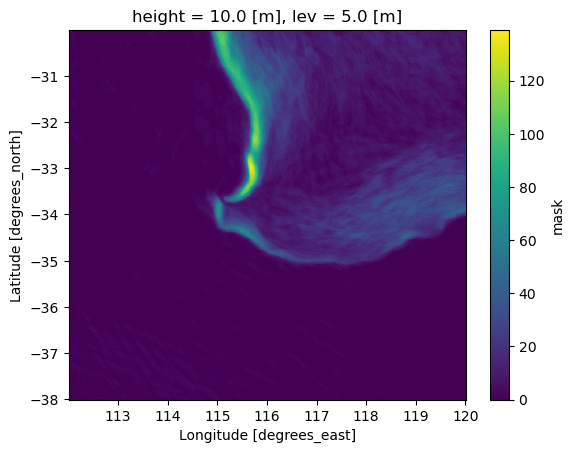

In [7]:
f_da = F_list[-1].mask.sel(lat=large_perth_lat,lon=large_perth_lon)
f_da.sum("time").plot()

f_da_hourly = F_list_hourly[-1].sel(lat=large_perth_lat,lon=large_perth_lon)

In [118]:
import pandas as pd
import datetime as dt

# era5_uas = load_model_data.load_era5_variable(
#             ["10u"],
#             f_da.time.min().values,
#             pd.to_datetime(f_da.time.max().values) + dt.timedelta(days=1),
#             slice(f_da.lon.min().values,f_da.lon.max().values),
#             slice(f_da.lat.min().values,f_da.lat.max().values),
#             chunks={})["10u"]["u10"].chunk({"time":1})

# era5_vas = load_model_data.load_era5_variable(
#             ["10v"],
#             f_da.time.min().values,
#             pd.to_datetime(f_da.time.max().values) + dt.timedelta(days=1),
#             slice(f_da.lon.min().values,f_da.lon.max().values),
#             slice(f_da.lat.min().values,f_da.lat.max().values),
#             chunks={})["10v"]["v10"].chunk({"time":1})

uas = []
vas= []
hus = []
times = [("2013-01-01 00:00","2013-02-28 23:00"),
         ("2016-01-01 00:00","2016-02-29 23:00"),
         ("2018-01-01 00:00","2018-02-28 23:00")]
exp = ["mjo-neutral2013","mjo-elnino2016","mjo-lanina2018"]
for t,e in zip(times,exp):

    vas.append(load_model_data.load_aus2200_variable(
                "vas",
                t[0],
                t[1],
                e,
                large_perth_lon,
                large_perth_lat,
                "1hr",
                chunks={},
                staggered="lat"))
    
    uas.append(load_model_data.load_aus2200_variable(
                "uas",
                t[0],
                t[1],
                e,
                large_perth_lon,
                large_perth_lat,
                "1hr",
                chunks={},
                staggered="lon"))

    hus.append(load_model_data.load_aus2200_variable(
                "hus",
                t[0],
                t[1],
                e,
                large_perth_lon,
                large_perth_lat,
                "1hr",
                hgt_slice=slice(0,10),
                chunks={}).sel(lev=5))

uas = xr.concat(uas,"time")
vas = xr.concat(vas,"time")
hus = xr.concat(hus,"time")

In [52]:
p_lat = -31.9514
p_lon = 115.8617

sb_days = (f_da.sel(lat=p_lat,lon=p_lon,method="nearest")==1).values

In [119]:
uas_comp_sb_list = []
vas_comp_sb_list = []
hus_comp_sb_list = []

for hh in [0,3,6,9,12,15]:

    print(hh)
    
    uas_daily = uas.sel(time=(np.in1d(uas.time.dt.date,f_da.time.dt.date)) & (uas.time.dt.hour==hh))
    uas_daily["time"] = uas_daily.time.dt.floor("d")
    uas_comp = uas_daily.sel(time=f_da.time[(np.in1d(f_da.time,uas_daily.time)) & (sb_days)]).mean("time").persist()
    uas_comp_sb_list.append(uas_comp)
    
    vas_daily = vas.sel(time=(np.in1d(vas.time.dt.date,f_da.time.dt.date)) & (vas.time.dt.hour==hh))
    vas_daily["time"] = vas_daily.time.dt.floor("d")
    vas_comp = vas_daily.sel(time=f_da.time[(np.in1d(f_da.time,vas_daily.time)) & (sb_days)]).mean("time").persist()
    vas_comp_sb_list.append(vas_comp)

    hus_daily = hus.sel(time=(np.in1d(hus.time.dt.date,f_da.time.dt.date)) & (hus.time.dt.hour==hh))
    hus_daily["time"] = hus_daily.time.dt.floor("d")
    hus_comp = hus_daily.sel(time=f_da.time[(np.in1d(f_da.time,hus_daily.time)) & (sb_days)]).mean("time").persist()
    hus_comp_sb_list.append(hus_comp)

0
3
6
9
12
15


In [120]:
uas_comp_nosb_list = []
vas_comp_nosb_list = []
hus_comp_nosb_list = []

for hh in [0,3,6,9,12,15]:

    print(hh)
    
    uas_daily = uas.sel(time=(np.in1d(uas.time.dt.date,f_da.time.dt.date)) & (uas.time.dt.hour==hh))
    uas_daily["time"] = uas_daily.time.dt.floor("d")
    uas_comp = uas_daily.sel(time=f_da.time[(np.in1d(f_da.time,uas_daily.time)) & (~sb_days)]).mean("time").persist()
    uas_comp_nosb_list.append(uas_comp)
    
    vas_daily = vas.sel(time=(np.in1d(vas.time.dt.date,f_da.time.dt.date)) & (vas.time.dt.hour==hh))
    vas_daily["time"] = vas_daily.time.dt.floor("d")
    vas_comp = vas_daily.sel(time=f_da.time[(np.in1d(f_da.time,vas_daily.time)) & (~sb_days)]).mean("time").persist()
    vas_comp_nosb_list.append(vas_comp)

    hus_daily = hus.sel(time=(np.in1d(hus.time.dt.date,f_da.time.dt.date)) & (hus.time.dt.hour==hh))
    hus_daily["time"] = hus_daily.time.dt.floor("d")
    hus_comp = hus_daily.sel(time=f_da.time[(np.in1d(f_da.time,hus_daily.time)) & (~sb_days)]).mean("time").persist()
    hus_comp_nosb_list.append(hus_comp)

0
3
6
9
12
15


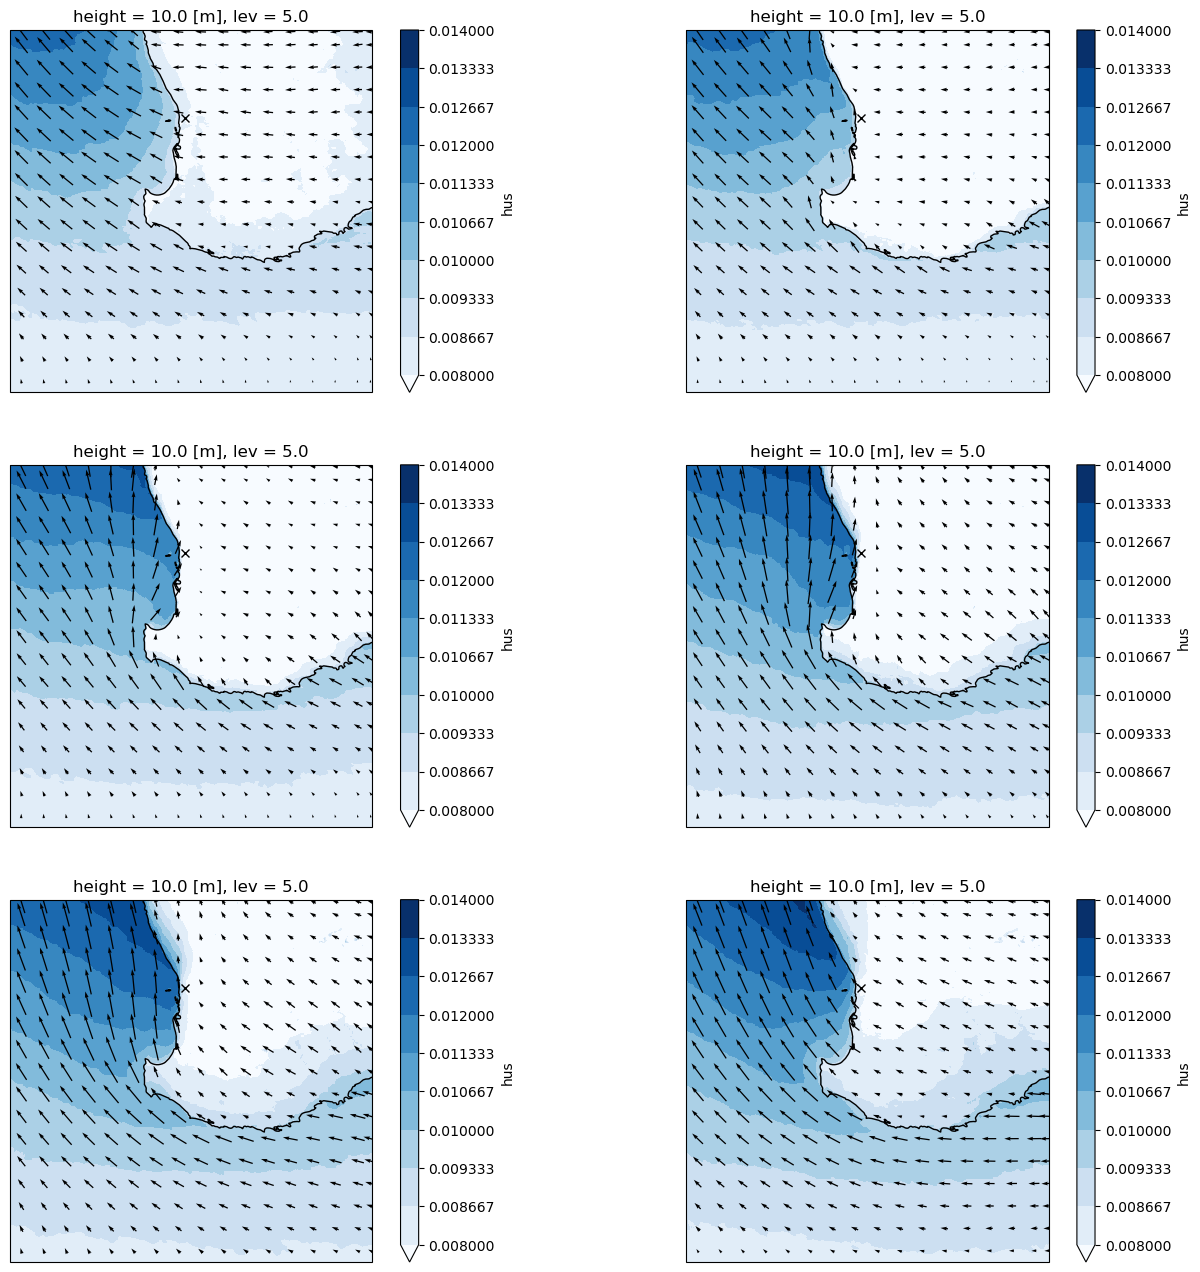

In [136]:
s=150
c=25

plt.figure(figsize=[16,16])
ax=plt.subplot(3,2,1,projection=ccrs.PlateCarree())
hus_comp_sb_list[0].plot(cmap="Blues",levels=10,vmin=0.008,vmax=0.014)
ax.plot(p_lon,p_lat,marker="x",color="k")
xr.Dataset({"u":uas_comp_sb_list[0],"v":vas_comp_sb_list[0]}).coarsen({"lon":c,"lat":c},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v",scale=s)
ax.coastlines()

ax=plt.subplot(3,2,2,projection=ccrs.PlateCarree())
hus_comp_sb_list[1].plot(cmap="Blues",levels=10,vmin=0.008,vmax=0.014)
ax.plot(p_lon,p_lat,marker="x",color="k")
xr.Dataset({"u":uas_comp_sb_list[1],"v":vas_comp_sb_list[1]}).coarsen({"lon":c,"lat":c},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v",scale=s)
ax.coastlines()

ax=plt.subplot(3,2,3,projection=ccrs.PlateCarree())
hus_comp_sb_list[2].plot(cmap="Blues",levels=10,vmin=0.008,vmax=0.014)
ax.plot(p_lon,p_lat,marker="x",color="k")
xr.Dataset({"u":uas_comp_sb_list[2],"v":vas_comp_sb_list[2]}).coarsen({"lon":c,"lat":c},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v",scale=s)
ax.coastlines()

ax=plt.subplot(3,2,4,projection=ccrs.PlateCarree())
hus_comp_sb_list[3].plot(cmap="Blues",levels=10,vmin=0.008,vmax=0.014)
ax.plot(p_lon,p_lat,marker="x",color="k")
xr.Dataset({"u":uas_comp_sb_list[3],"v":vas_comp_sb_list[3]}).coarsen({"lon":c,"lat":c},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v",scale=s)
ax.coastlines()

ax=plt.subplot(3,2,5,projection=ccrs.PlateCarree())
hus_comp_sb_list[4].plot(cmap="Blues",levels=10,vmin=0.008,vmax=0.014)
ax.plot(p_lon,p_lat,marker="x",color="k")
xr.Dataset({"u":uas_comp_sb_list[4],"v":vas_comp_sb_list[4]}).coarsen({"lon":c,"lat":c},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v",scale=s)
ax.coastlines()

ax=plt.subplot(3,2,6,projection=ccrs.PlateCarree())
hus_comp_sb_list[5].plot(cmap="Blues",levels=10,vmin=0.008,vmax=0.014)
ax.plot(p_lon,p_lat,marker="x",color="k")
xr.Dataset({"u":uas_comp_sb_list[5],"v":vas_comp_sb_list[5]}).coarsen({"lon":c,"lat":c},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v",scale=s)
ax.coastlines()

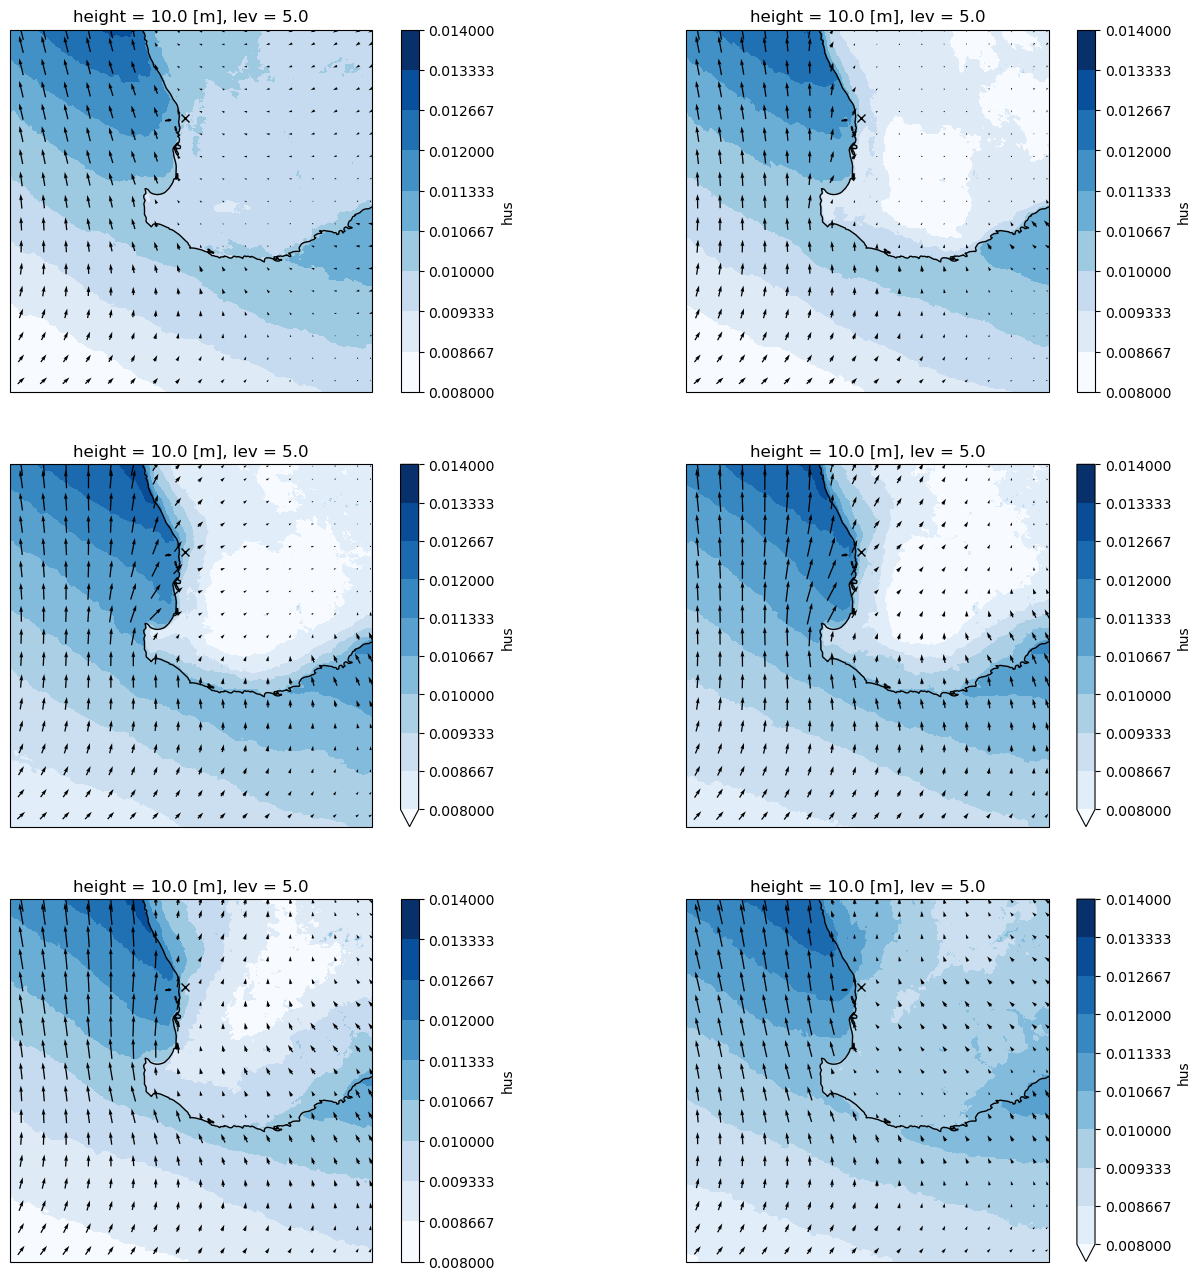

In [137]:
s=150
c=25

plt.figure(figsize=[16,16])
ax=plt.subplot(3,2,1,projection=ccrs.PlateCarree())
hus_comp_nosb_list[0].plot(cmap="Blues",levels=10,vmin=0.008,vmax=0.014)
ax.plot(p_lon,p_lat,marker="x",color="k")
xr.Dataset({"u":uas_comp_nosb_list[0],"v":vas_comp_nosb_list[0]}).coarsen({"lon":c,"lat":c},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v",scale=s)
ax.coastlines()

ax=plt.subplot(3,2,2,projection=ccrs.PlateCarree())
hus_comp_nosb_list[1].plot(cmap="Blues",levels=10,vmin=0.008,vmax=0.014)
ax.plot(p_lon,p_lat,marker="x",color="k")
xr.Dataset({"u":uas_comp_nosb_list[1],"v":vas_comp_nosb_list[1]}).coarsen({"lon":c,"lat":c},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v",scale=s)
ax.coastlines()

ax=plt.subplot(3,2,3,projection=ccrs.PlateCarree())
hus_comp_nosb_list[2].plot(cmap="Blues",levels=10,vmin=0.008,vmax=0.014)
ax.plot(p_lon,p_lat,marker="x",color="k")
xr.Dataset({"u":uas_comp_nosb_list[2],"v":vas_comp_nosb_list[2]}).coarsen({"lon":c,"lat":c},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v",scale=s)
ax.coastlines()

ax=plt.subplot(3,2,4,projection=ccrs.PlateCarree())
hus_comp_nosb_list[3].plot(cmap="Blues",levels=10,vmin=0.008,vmax=0.014)
ax.plot(p_lon,p_lat,marker="x",color="k")
xr.Dataset({"u":uas_comp_nosb_list[3],"v":vas_comp_nosb_list[3]}).coarsen({"lon":c,"lat":c},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v",scale=s)
ax.coastlines()

ax=plt.subplot(3,2,5,projection=ccrs.PlateCarree())
hus_comp_nosb_list[4].plot(cmap="Blues",levels=10,vmin=0.008,vmax=0.014)
ax.plot(p_lon,p_lat,marker="x",color="k")
xr.Dataset({"u":uas_comp_nosb_list[4],"v":vas_comp_nosb_list[4]}).coarsen({"lon":c,"lat":c},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v",scale=s)
ax.coastlines()

ax=plt.subplot(3,2,6,projection=ccrs.PlateCarree())
hus_comp_nosb_list[5].plot(cmap="Blues",levels=10,vmin=0.008,vmax=0.014)
ax.plot(p_lon,p_lat,marker="x",color="k")
xr.Dataset({"u":uas_comp_nosb_list[5],"v":vas_comp_nosb_list[5]}).coarsen({"lon":c,"lat":c},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v",scale=s)
ax.coastlines()

In [72]:
#era5_vas_comp_list = []

#for hh in [0,3,6,9,12,15]:
hh=9
print(hh)

labels_daily = f_da_hourly.sel(time=(np.in1d(f_da_hourly.time.dt.date,f_da.time.dt.date)) & (f_da_hourly.time.dt.hour==hh))
labels_daily["time"] = labels_daily.time.dt.floor("d")
labels_daily_comp = labels_daily.sel(time=f_da.time[(np.in1d(f_da.time,uas_daily.time)) & (sb_days)]).mask.sum("time").persist()
labels_daily_comp_nosb = labels_daily.sel(time=f_da.time[(np.in1d(f_da.time,uas_daily.time)) & (~sb_days)]).mask.sum("time").persist()

#F_list_hourly[0].filtered_labels.sel(time=f_da.sel(lat=p_lat,lon=p_lon,method="nearest"))

9


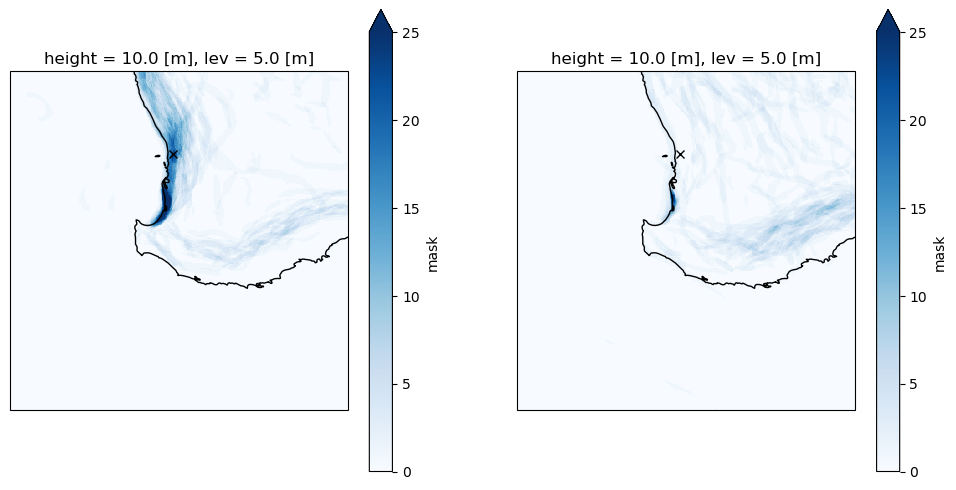

In [75]:
plt.figure(figsize=[12,6])

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
labels_daily_comp.plot(cmap="Blues",vmin=0,vmax=25)
ax.plot(p_lon,p_lat,marker="x",color="k")
ax.coastlines()

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
labels_daily_comp_nosb.plot(cmap="Blues",vmin=0,vmax=25)
ax.plot(p_lon,p_lat,marker="x",color="k")
ax.coastlines()

In [76]:
f_da

<xarray.DataArray 'mask' (time: 178, lat: 404, lon: 404)> Size: 29MB
dask.array<getitem, shape=(178, 404, 404), dtype=bool, chunksize=(4, 404, 404), chunktype=numpy.ndarray>
Coordinates:
    height   float64 8B 10.0
  * lat      (lat) float64 3kB -38.0 -37.98 -37.96 ... -30.06 -30.04 -30.02
    lev      float64 8B 5.0
  * lon      (lon) float64 3kB 112.0 112.0 112.1 112.1 ... 120.0 120.0 120.0
  * time     (time) datetime64[ns] 1kB 2013-01-01 2013-01-02 ... 2018-02-28
Attributes: (12/27)
    area_filter:                       True
    area_filter_units:                 pixels
    area_thresh_km:                    50
    area_thresh_pixels:                12
    aspect_filter:                     True
    aspect_thresh:                     2
    ...                                ...
    temperature_change_thresh:         0
    threshold:                         18.796545
    threshold_method:                  fixed
    time_filter:                       False
    wind_change_filter:                False
    wind_change_thresh:                0

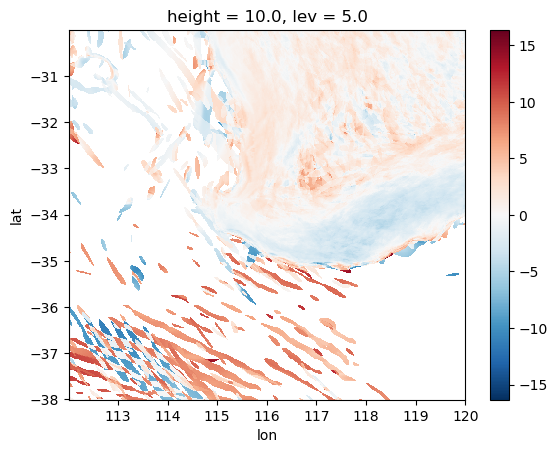

In [84]:
uas_daily = uas.sel(time=(np.in1d(uas.time.dt.date,f_da.time.dt.date)) & (uas.time.dt.hour==hh))
uas_daily["time"] = uas_daily.time.dt.floor("d")
xr.where(f_da==1,uas_daily,np.nan).mean("time").plot()

In [92]:
np.in1d(uas.time.dt.date

<xarray.DataArray 'date' (time: 4269)> Size: 34kB
array([datetime.date(2013, 1, 1), datetime.date(2013, 1, 1),
       datetime.date(2013, 1, 1), ..., datetime.date(2018, 2, 28),
       datetime.date(2018, 2, 28), datetime.date(2018, 2, 28)],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 34kB 2013-01-01T00:30:00 ... 2018-02-28T22...
    height   float64 8B 10.0
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

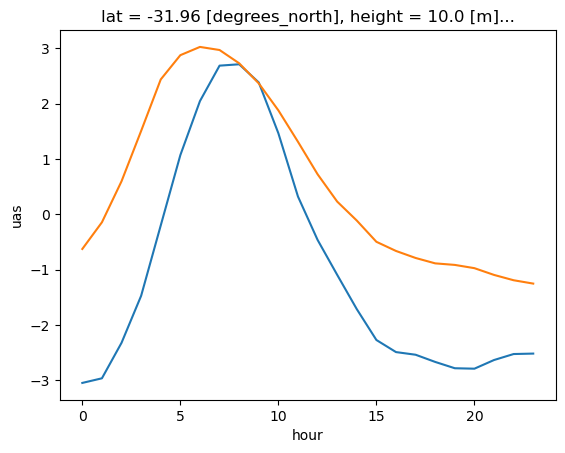

In [110]:
uas.sel(
    time=np.in1d(uas.time.dt.date, f_da.time[(np.in1d(f_da.time,uas_daily.time)) & (sb_days)].dt.date),
    lat=p_lat,
    lon=p_lon,method="nearest").groupby("time.hour").mean().plot()


uas.sel(
    time=np.in1d(uas.time.dt.date, f_da.time[(np.in1d(f_da.time,uas_daily.time)) & (~sb_days)].dt.date),
    lat=p_lat,
    lon=p_lon,method="nearest").groupby("time.hour").mean().plot()